In [1]:
import dgl
import dgl.nn as dglnn
from dgl import from_networkx
import torch
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('../../../Untitled Folder 1/bot_iot/bot.csv')

/tmp/ipykernel_3188/3993269919.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../Untitled Folder 1/bot_iot/bot.csv')


In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','attack','state','proto','seq','rate','srate','AR_P_Proto_P_DstIP',
                   'bytes', 'state_number','Pkts_P_State_P_Protocol_P_SrcIP', 'spkts', 'pkts', 'dbytes', 'mean', 'TnP_PSrcIP',
                   'max', 'TnBPSrcIP', 'min', 'drate', 'dpkts', 'flgs_number'],inplace=True)

In [4]:
data.rename(columns={"category": "label"},inplace = True)

In [5]:
data.label.value_counts()

DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: label, dtype: int64

In [6]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [7]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [8]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [9]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
# data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [10]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [11]:
data.fillna(0,inplace = True)

In [12]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [13]:
data.drop(columns=['index'],inplace=True)

In [14]:
data

,proto_number,saddr,daddr,ltime,dur,stddev,sum,sbytes,TnBPDstIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,label
0,1,192.168.100.147:49960,192.168.100.7:80,1.528089e+09,7.056393,0.068909,0.137818,650,201841,770,772,772,1.142970,96,75,1.133720,1.129970,770,1
1,2,192.168.100.7:-1,192.168.100.147:-1,1.528089e+09,0.000131,0.000000,0.000131,60,120,2,8,8,0.003857,1,2,0.005142,0.005142,2,1
2,1,192.168.100.147:49962,192.168.100.7:80,1.528089e+09,7.047852,0.064494,0.128988,796,201841,770,772,772,1.142970,96,75,1.135100,1.129970,770,1
3,1,192.168.100.147:49964,192.168.100.7:80,1.528089e+09,7.047592,0.064189,0.128378,694,201841,770,772,772,1.142970,96,75,1.135140,1.129970,770,1
4,1,192.168.100.147:49966,192.168.100.7:80,1.528089e+09,7.046841,0.063887,0.127774,989,201841,770,772,772,1.142970,96,75,1.135260,1.129970,770,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,1,192.168.100.150:35064,192.168.100.3:22,1.529381e+09,0.013165,0.000000,0.013165,228,79240,471,475,471,9.889330,19,19,455.754000,9.889330,30,4
3668518,1,192.168.100.150:35066,192.168.100.3:22,1.529381e+09,0.000574,0.000000,0.000574,228,79240,471,475,471,9.889330,19,19,10453.000000,9.889330,30,4
3668519,1,192.168.100.150:35070,192.168.100.3:22,1.529381e+09,2.874302,0.000000,2.874302,1802,79240,471,475,471,9.889330,19,19,10.785200,9.889330,441,4
3668520,1,192.168.100.3:43001,192.168.100.150:4433,1.529381e+09,0.000003,0.000000,0.000003,74,134,2,475,4,22346.400000,1,3,666667.000000,22346.400000,2,4


In [15]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 0:].columns ))  - set(list(['label','saddr','daddr'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=123, stratify=label_ground_truth.label)

In [17]:
X_train['h'] = X_train[cols_to_norm].values.tolist()

In [18]:
G = nx.from_pandas_edgelist(X_train, "daddr", "saddr",  ['h','label'],create_using=nx.MultiDiGraph)

In [19]:
G.number_of_edges()

2567965

In [20]:
G1 = nx.from_pandas_edgelist(X_train, "daddr", "saddr",create_using=nx.MultiGraph)

In [21]:
G1.number_of_edges()

2567965

In [22]:
G1 = G1.to_directed()

In [23]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [24]:
G1 = from_networkx(G1)

In [25]:
G1 = dgl.add_self_loop(G1)

In [26]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [27]:
G

Graph(num_nodes=272559, num_edges=2567965,
      ndata_schemes={}
      edata_schemes={'h': Scheme(shape=(16,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [28]:
G1

Graph(num_nodes=272559, num_edges=5408489,
      ndata_schemes={}
      edata_schemes={})

In [29]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [30]:
from dgl.utils import expand_as_pair
from dgl.nn.functional import edge_softmax
class GATConv(nn.Module):
    def __init__(
        self,
        in_feats,
        out_feats,
        feat_drop=0.0,
        attn_drop=0.0,
        negative_slope=0.2,
    ):
        super(GATConv, self).__init__()
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        
        self.fc = nn.Linear(
            self._in_src_feats, out_feats, bias=False
        )
        
        self.attn = nn.Parameter(
            th.FloatTensor(size=(1, out_feats))
        )

        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.leaky_relu = nn.LeakyReLU(negative_slope)

        
        self.reset_parameters()
       
    
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        
        nn.init.xavier_normal_(self.fc.weight, gain=gain)

        nn.init.xavier_normal_(self.attn, gain=gain)

    
    def message_func(self, edges):
        return {'m': edges.data['a'] * edges.data['ft']}
    
    def forward(self, graph, efeat):
        with graph.local_scope(): 
            efeat = self.feat_drop(efeat)
            efeat = self.fc(efeat)
            graph.edata['ft'] = efeat
            e = (efeat * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['e']= e         
            e = self.leaky_relu(graph.edata.pop('e'))
            graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            # message passing
            graph.update_all(self.message_func, fn.sum('m', 'ft'))
            rst = graph.ndata['ft']
            return rst,efeat

In [31]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 3, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        h_e = edges.data['e']
        score = self.W(th.cat([h_u, h_v, h_e], 1))
        return {'score': score}

    def forward(self, graph, h, e):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.edata['e'] = e
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [32]:
class SAGEConv(nn.Module):
   
    def __init__(
        self,
        in_feats,
        out_feats,
        k=2,
        feat_drop=0.2,
        cached=False,
        bias=True,
    ):
        super(SAGEConv, self).__init__()
        self.fc = nn.Linear(in_feats, out_feats, bias=bias)
        self._k = k
        self.feat_drop = nn.Dropout(feat_drop)
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
        
    def forward(self, graph, feat, edge_weight=None):
        with graph.local_scope():
          
            msg_fn = fn.copy_u("h", "m")
            
            for _ in range(self._k):
                h_self = self.feat_drop(feat)
                graph.ndata["h"] = h_self
                graph.update_all(msg_fn, fn.mean("m", "neigh"))
#                 feat = self.feat_drop(graph.ndata.pop("neigh"))
                h_neigh = graph.ndata.pop("neigh")
                feat = h_neigh
            return self.fc(feat)

In [33]:
class Model(nn.Module):
    def __init__(self, edim_in, edim_out, ndim_out):
        super().__init__()
        self.gat = GATConv(edim_in, ndim_out)
        self.conv1 = SAGEConv(ndim_out, edim_out, k=2)
        self.pred = MLPPredictor(edim_out, 5)
    def forward(self, g, g1, efeats):
        h,e = self.gat(g, efeats)
        h = F.relu(h)
        h = self.conv1(g1, h)
        return self.pred(g, h, e)

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
G = G.to('cuda:0')
G1 = G1.to('cuda:0')

In [37]:
import time
start_time = time.time()

edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.edata['h'].shape[1], 8, 8).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,12000):
    pred = model(G, G1, edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('epoc:{} Training acc:{} loss:{}'.format(epoch, compute_accuracy(pred[train_mask], edge_label[train_mask]), loss))
        
end_time = time.time()
execution_time = end_time - start_time
print(f"程序执行时间为：{execution_time} 秒")

epoc:100 Training acc:0.5865971446037292 loss:1.4381952285766602
epoc:200 Training acc:0.7628386616706848 loss:0.7279762625694275
epoc:300 Training acc:0.8780707716941833 loss:0.385198712348938
epoc:400 Training acc:0.8912485241889954 loss:0.33372199535369873
epoc:500 Training acc:0.910602331161499 loss:0.3080088794231415
epoc:600 Training acc:0.9163469672203064 loss:0.2915481925010681
epoc:700 Training acc:0.9194969534873962 loss:0.2760699987411499
epoc:800 Training acc:0.9250959157943726 loss:0.27278855443000793
epoc:900 Training acc:0.9105346202850342 loss:0.30420631170272827
epoc:1000 Training acc:0.9299597144126892 loss:0.2611791491508484
epoc:1100 Training acc:0.9308506846427917 loss:0.25459977984428406
epoc:1200 Training acc:0.9161051511764526 loss:0.2609000504016876
epoc:1300 Training acc:0.9322498440742493 loss:0.2493111938238144
epoc:1400 Training acc:0.9344983100891113 loss:0.23955179750919342
epoc:1500 Training acc:0.9276820421218872 loss:0.24328023195266724
epoc:1600 Train

In [38]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [39]:
G_test = nx.from_pandas_edgelist(X_test, "daddr", "saddr", ['h','label'],create_using=nx.MultiDiGraph)
G1_test = nx.from_pandas_edgelist(X_test, "daddr", "saddr",create_using=nx.MultiGraph)
G1_test = G1_test.to_directed()
G_test = from_networkx(G_test, edge_attrs=['h','label'])
G1_test = from_networkx(G1_test)
G1_test = dgl.add_self_loop(G1_test)
actual = G_test.edata.pop('label')

In [40]:
G_test = G_test.to('cuda:0')
G1_test = G1_test.to('cuda:0')

In [41]:
th.cuda.empty_cache()

In [42]:
import timeit

edge_features_test = G_test.edata['h']

torch.cuda.synchronize()
start_time = timeit.default_timer()

with torch.no_grad():
    test_pred =model(G_test, G1_test, edge_features_test).cuda()

torch.cuda.synchronize()
elapsed = timeit.default_timer() - start_time

In [43]:
print(str(elapsed) + ' seconds')

0.003116206000413513 seconds


In [44]:
print(elapsed/len(X_test))

2.831480786922906e-09


In [45]:
test_pred = test_pred.argmax(1)

In [46]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [47]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

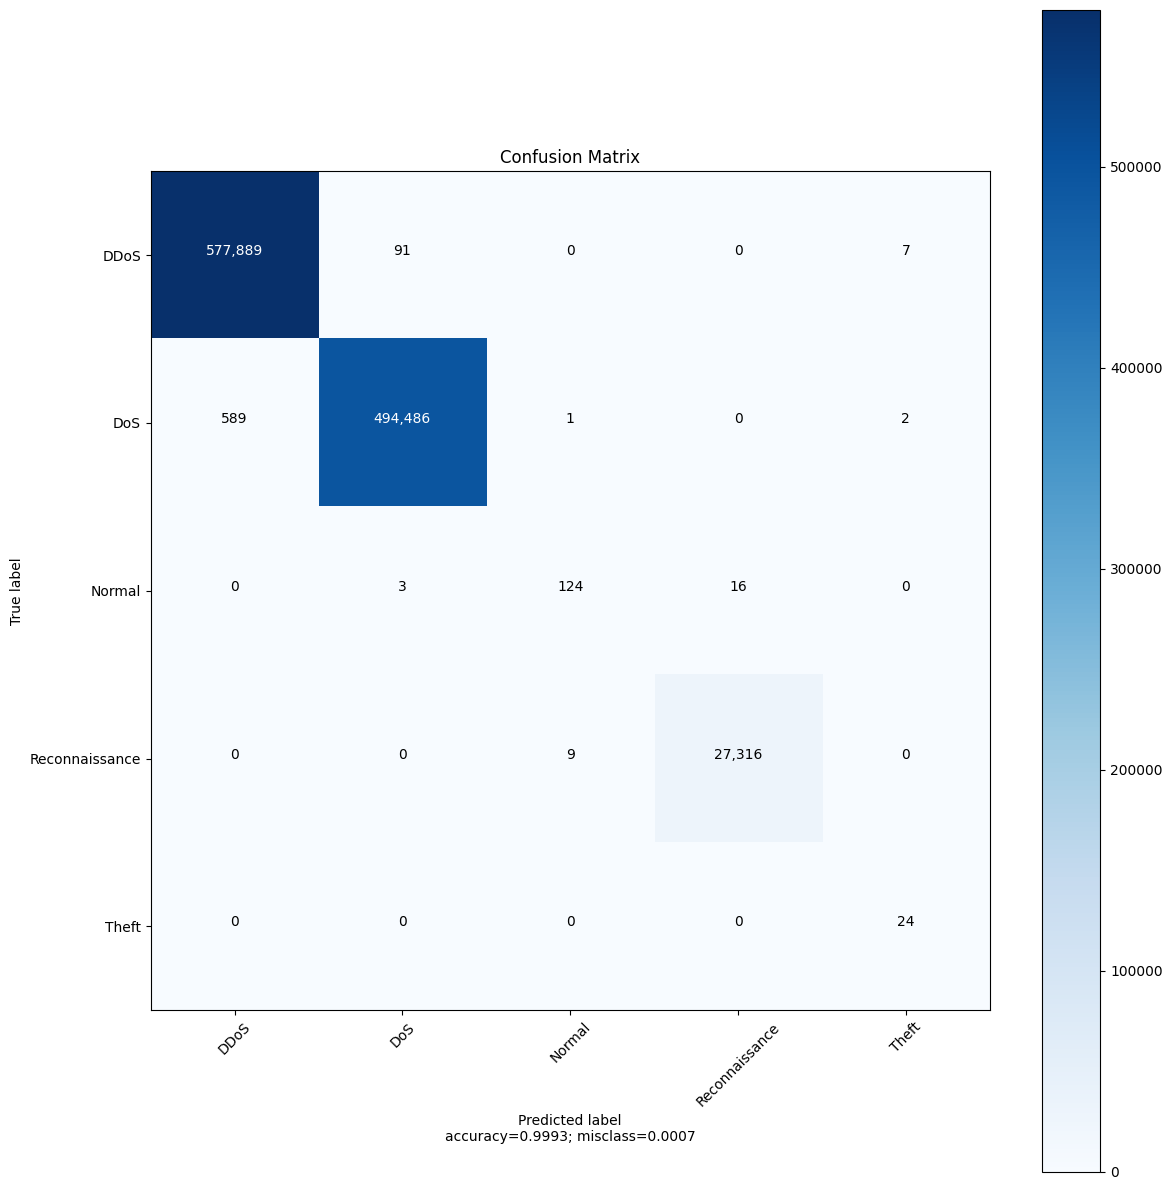

In [49]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")

In [50]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          title_fontsize=14):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()

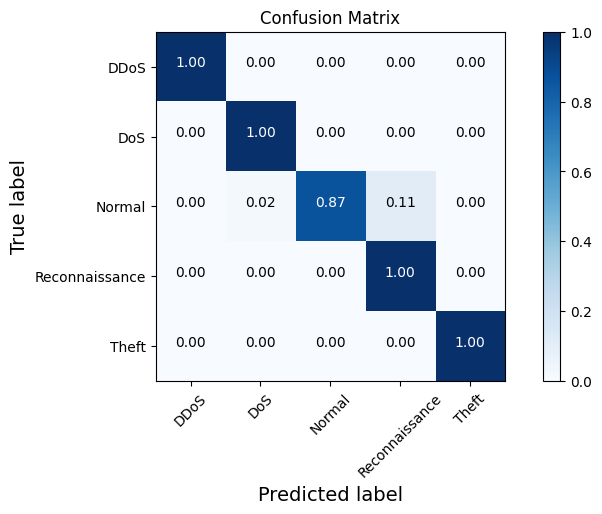

In [51]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = True,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")

In [52]:
from sklearn.metrics import classification_report
target_names = np.unique(edge_label)
print(classification_report(edge_label, test_pred, target_names=target_names, digits=4))

                precision    recall  f1-score   support

          DDoS     0.9990    0.9998    0.9994    577987
           DoS     0.9998    0.9988    0.9993    495078
        Normal     0.9254    0.8671    0.8953       143
Reconnaissance     0.9994    0.9997    0.9995     27325
         Theft     0.7273    1.0000    0.8421        24

      accuracy                         0.9993   1100557
     macro avg     0.9302    0.9731    0.9471   1100557
  weighted avg     0.9993    0.9993    0.9993   1100557



In [53]:
cm = confusion_matrix(edge_label, test_pred)
class_acc = {}
for i in range(len(cm)):
    class_ac = cm[i,i]/cm[i,:].sum()
    class_acc[i] = class_ac
    
for class_label, acc in class_acc.items():
    print(f"class {class_label} acc", acc)

class 0 acc 0.9998304460134917
class 1 acc 0.9988042288285887
class 2 acc 0.8671328671328671
class 3 acc 0.9996706312900274
class 4 acc 1.0


In [54]:
model.parameters()
print(sum(p.numel() for p in model.parameters())*4)

1332


In [55]:
from thop import profile
flops, params = profile(model, inputs=(G, G1, edge_features))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1048576.0))

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
flops:  654299096.0 params:  325.0
flops: 654.30 M, params: 0.00 M


In [56]:
total_bits = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        total_bits += param.numel() * param.element_size()
        print(f"Parameter name: {name}, Shape: {param.shape}")

print(f"Total number of parameters: {total_bits} B")

Parameter name: gat.attn, Shape: torch.Size([1, 8])
Parameter name: gat.fc.weight, Shape: torch.Size([8, 16])
Parameter name: conv1.fc.weight, Shape: torch.Size([8, 8])
Parameter name: conv1.fc.bias, Shape: torch.Size([8])
Parameter name: pred.W.weight, Shape: torch.Size([5, 24])
Parameter name: pred.W.bias, Shape: torch.Size([5])
Total number of parameters: 1332 B


In [57]:
torch.save(model, 'model.pth')

In [58]:
import torch


# 加载模型之前的内存量
initial_memory = torch.cuda.memory_allocated()

# 加载模型
model_100 = torch.load('model.pth')

# 加载模型后的内存量
final_memory = torch.cuda.memory_allocated()

# 计算模型大小的增量
model_size = final_memory - initial_memory
print("模型大小（增量）：", model_size, "字节")

模型大小（增量）： 3072 字节
